### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#! pip install ads
#! pip install seaborn

In [1]:
import gzip
import pickle
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automl
from automl import init

In [33]:
from sklearn import metrics, linear_model, tree, discriminant_analysis, ensemble, neural_network, inspection
from sklearn.pipeline import make_pipeline

In [2]:
column_names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                 names=column_names, sep=',\s*', na_values='?', keep_default_na=False, engine='python')
test_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
                      names=column_names, sep=',\s*', na_values='?', skiprows=1, engine='python')

In [3]:
df.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [4]:
pd.DataFrame({'Data type': df.dtypes}).T

age workclass fnlwgt education education-num marital-status  \
Data type  int64    object  int64    object         int64         object   

          occupation relationship    race     sex capital-gain capital-loss  \
Data type     object       object  object  object        int64        int64   

          hours-per-week native-country  income  
Data type          int64         object  object

In [5]:
pd.DataFrame({'% missing values': df.isnull().sum() * 100 / len(df)}).T

age  workclass  fnlwgt  education  education-num  \
% missing values  0.0   5.638647     0.0        0.0            0.0   

                  marital-status  occupation  relationship  race  sex  \
% missing values             0.0    5.660146           0.0   0.0  0.0   

                  capital-gain  capital-loss  hours-per-week  native-country  \
% missing values           0.0           0.0             0.0        1.790486   

                  income  
% missing values     0.0

<AxesSubplot:xlabel='income', ylabel='count'>

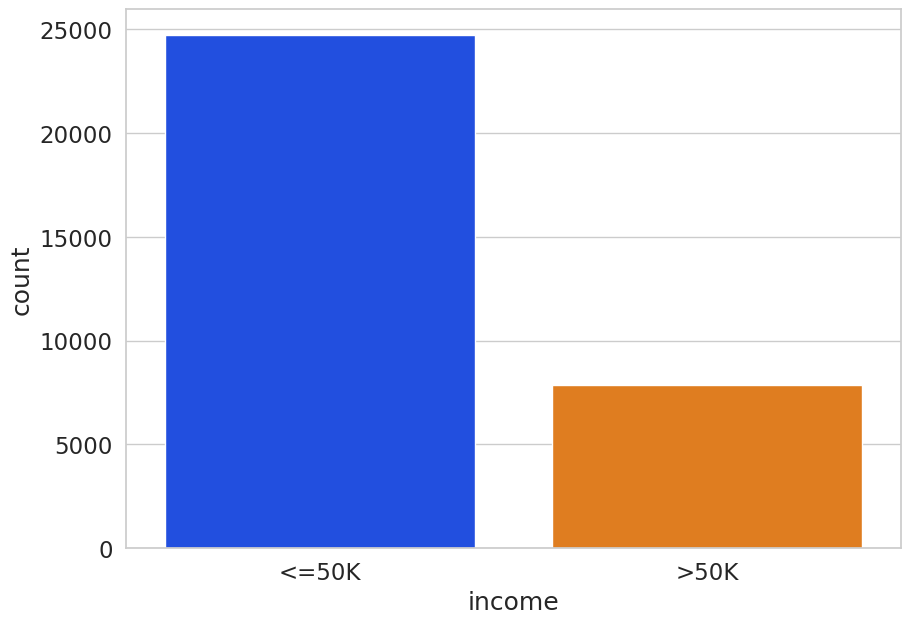

In [6]:
sns.countplot(x="income", data=df)

In [7]:
target_col = 'income'

X_train = df.drop(target_col, axis=1)
y_train = df[target_col].map({"<=50K":0, ">50K":1})
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col].map({"<=50K.":0, ">50K.":1})

X_train.shape, X_test.shape

((32561, 14), (16281, 14))

# Pipeline com Scikit learn

In [80]:
rand = 9
df2 = df
test_df = df2

In [81]:
df2.shape[1]


15

In [82]:
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
for i in df2.columns:
    df2[i] = le.fit_transform(df2[i])

ValueError: Expected 2D array, got 1D array instead:
array=[22 33 21 ... 41  5 35].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [78]:
df2

age  workclass  fnlwgt  education  education-num  marital-status  \
0       22          6    2671          9             12               4   
1       33          5    2926          9             12               2   
2       21          3   14086         11              8               0   
3       36          3   15336          1              6               2   
4       11          3   19355          9             12               2   
...    ...        ...     ...        ...            ...             ...   
32556   10          3   16528          7             11               2   
32557   23          3    8080         11              8               2   
32558   41          3    7883         11              8               6   
32559    5          3   12881         11              8               4   
32560   35          4   17825         11              8               2   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
0               0             1     4    1            25             0   
1               3             0     4    1             0             0   
2               5             1     4    1             0             0   
3               5             0     2    1             0             0   
4               9             5     2    0             0             0   
...           ...           ...   ...  ...           ...           ...   
32556          12             5     4    0             0             0   
32557           6             0     4    1             0             0   
32558           0             4     4    0             0             0   
32559           0             3     4    1             0             0   
32560           3             5     4    0           108             0   

       hours-per-week  native-country  income  
0                  39              38       0  
1                  12              38       0  
2                  39              38       0  
3                  39              38       0  
4                  39               4       0  
...               ...             ...     ...  
32556              37              38       0  
32557              39              38       1  
32558              39              38       0  
32559              19              38       0  
32560              39              38       1  

[32561 rows x 15 columns]

In [79]:
class_models = {'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=6, random_state=rand,class_weight='balanced')},
'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=200,max_depth=4, subsample=0.5,learning_rate=0.05)},
'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11, n_estimators=300,max_features='sqrt', random_state=rand)},
'logistic':{'model': linear_model.LogisticRegression(multi_class='ovr', solver='lbfgs',class_weight='balanced', max_iter=500)},
'lda':{'model':discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)},
'mlp':{'model':make_pipeline(StandardScaler(), neural_network.MLPClassifier(hidden_layer_sizes=(11,),early_stopping=True, random_state=rand,validation_fraction=0.25, max_iter=500))}
}

In [ ]:
target_col = 'income'

X_train = df2.drop(target_col, axis=1)
y_train = df2[target_col].map({"<=50K":0, ">50K":1})
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col].map({"<=50K.":0, ">50K.":1})

X_train.shape, X_test.shape

In [38]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train)
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.Accuracy_score(y_train, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.Accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.Recall_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Recall_test'] = metrics.Recall_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['Precision_train'] = metrics.Precision_score(y_train, y_train_pred,average='weighted')
    class_models[model_name]['Precision_test'] = metrics.Precision_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test, y_test_pred)

ValueError: could not convert string to float: 'State-gov'

In [ ]:
target_col = 'income'

X_train = df.drop(target_col, axis=1)
y_train = df[target_col].map({"<=50K":0, ">50K":1})
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col].map({"<=50K.":0, ">50K.":1})

X_train.shape, X_test.shape

In [8]:
init(engine = 'local')

[2023-03-15 13:14:15,038] [automl.xengine] Local ProcessPool execution (n_jobs=4)


In [9]:
est1 = automl.Pipeline(task='classification')


[2023-03-15 13:14:16,059] [automl.pipeline] Random state (7) is used for model builds


In [10]:
est1.fit(X_train, y_train)


[2023-03-15 13:14:19,653] [automl.pipeline] Dataset shape: (32561, 14)
[2023-03-15 13:14:19,666] [automl.pipeline] Running Auto-Preprocessing
[2023-03-15 13:14:20,002] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (32561, 15), cv: 5
[2023-03-15 13:14:20,049] [automl.pipeline] SVC, KNeighborsClassifier are disabled for datasets with > 10K samples or > 1K features
[2023-03-15 13:14:20,050] [automl.pipeline] Running Model Selection
[2023-03-15 13:14:45,549] [automl.pipeline] Model Selection completed. Selected model: ['LGBMClassifier']
[2023-03-15 13:14:45,551] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (32561, 15), Valid Shape: None, CV: 5, Class counts: [24720  7841]
[2023-03-15 13:14:53,964] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (32561, 15), Valid Shape: None, CV: [(18538, 6513), (18539, 6512), (18539, 6512), (18539, 6512), (18539, 6512)], Class counts: [24720  7841]
[2023-03-15 13:14:53,966] [automl.pipeline] Startin

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier'])

In [13]:
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test, y_proba[:, 1])
print(f'Score on test data : {score_default}')

Score on test data : 0.9269539410446543


During the AutoML process, a summary of the optimization process is logged. It consists of:

Information about the training data
Information about the AutoML Pipeline, such as:
selected features that AutoML found to be most predictive in the training data;
selected algorithm that was the best choice for this data;
hyperparameters for the selected algorithm.
AutoML provides a print_summary API to output all the different trials performed.

In [14]:
est1.print_summary()

We also provide the capability to visualize the results of each stage of the AutoML pipeline. The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal. Here we can see that the LightGBM classifier achieved the highest predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

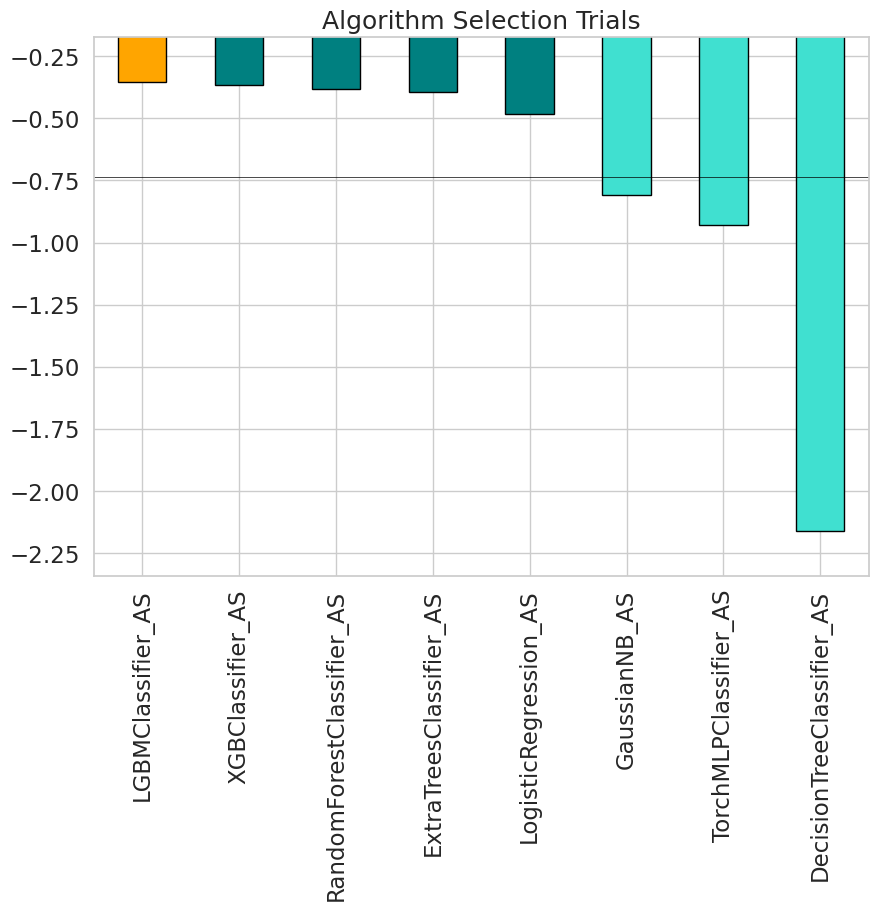

In [15]:
# array of (algorithm, predicted score, cpu time)
trials = est1.model_selection_trials_
fig, ax = plt.subplots(1)
colors = []
scores = [x[3] for x in trials]
models = [x[0] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
ax.set_title("Algorithm Selection Trials")
for f in s.keys():
    if f == '{}_AS'.format(est1.selected_model_):
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()


Following Algorithm Selection, Adaptive Sampling aims to find the smallest dataset sample that can be created without compromising validation set score for the chosen model (LGBM). Given the small size of the training data (455 samples), Adaptive Sampling is not applied there.

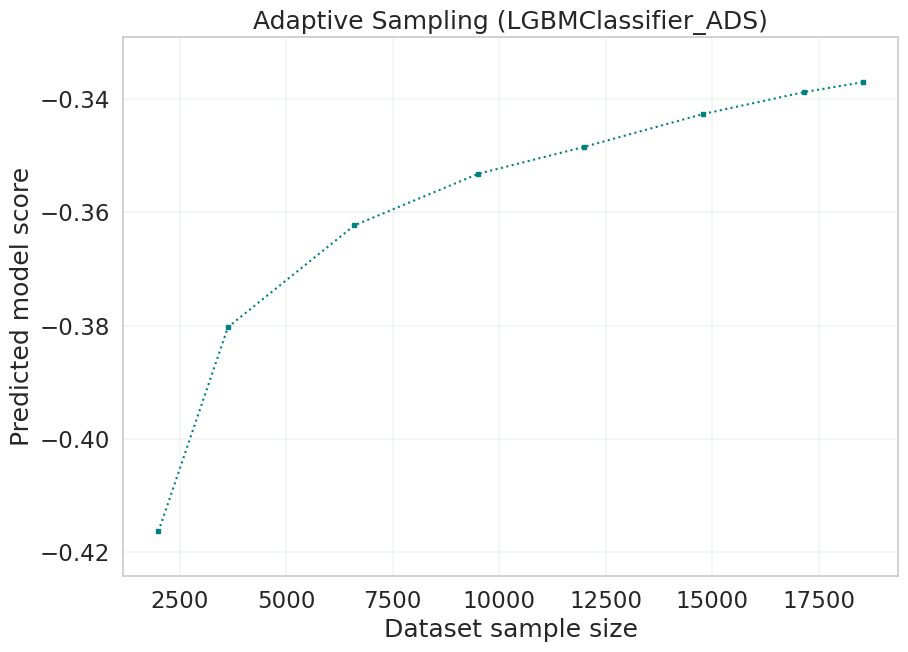

In [16]:
trials = est1.adaptive_sampling_trials_
fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(trials[0][0]))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel(r"Predicted model score")
scores = [x[3] for x in trials]
n_samples = [x[1] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

After finding a sample subset, the next step is to find a relevant feature subset to maximize score for the chosen algorithm. The Feature Selection step identifies the smallest feature subset that does not compromise on the score of the chosen algorithm. The orange line shows the optimal number of features chosen by Feature Selection.

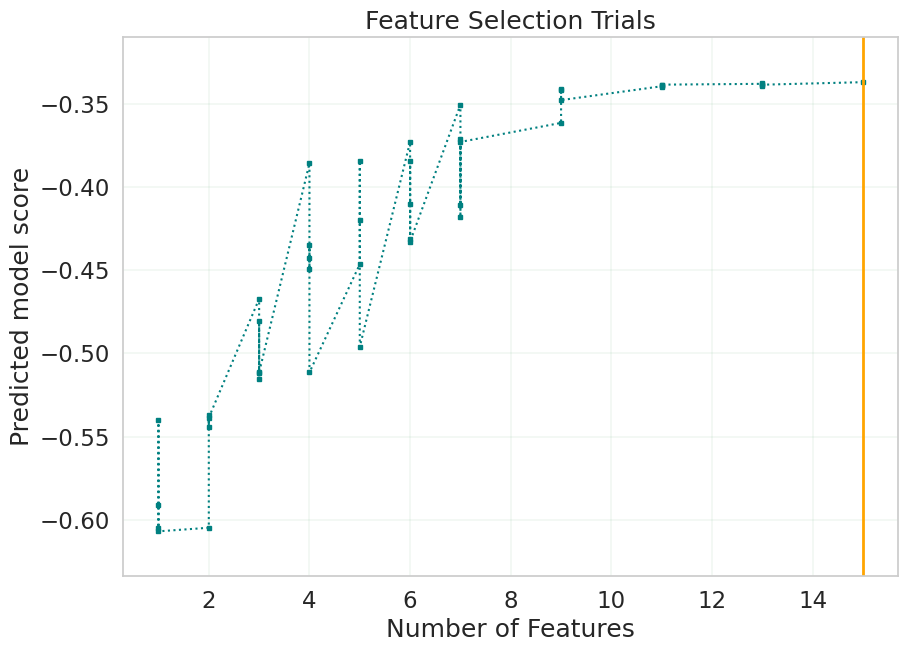

In [17]:
trials = est1.feature_selection_trials_
fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel("Number of Features")
ax.set_ylabel(r"Predicted model score")
scores = [x[3] for x in trials]
n_features = [x[2] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color='orange', linewidth=2.0)
plt.show()

Hyperparameter Tuning is the last stage of the AutoML pipeline, and focuses on improving the chosen algorithm's score on the reduced dataset (after Adaptive Sampling and Feature Selection). We use a novel algorithm to search across many hyperparameters dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameters configuration for the selected model.

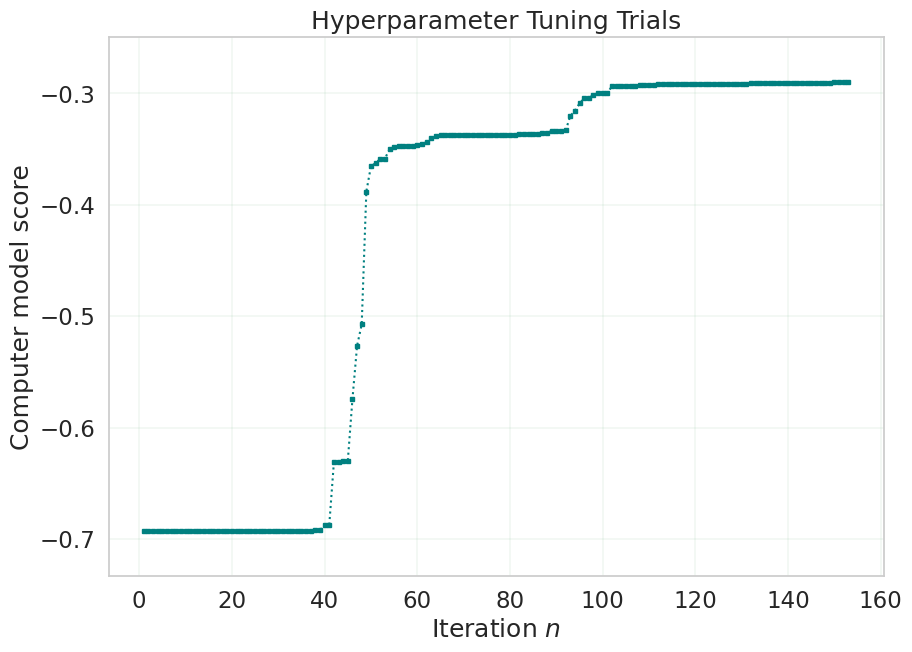

In [18]:
trials = est1.tuning_trials_
fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(r"Computer model score")
scores = [x[3] for x in reversed(trials)]
y_margin = 0.10 * (max(scores) - min(scores))
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(range(1, len(trials) + 1), scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

# Save Models


### After you have trained your model, you may want to save it for future use or implementation somewhere else Note: please insure you have the appropriate permissions to write the model to the current directory.


In [18]:
with gzip.open('oracle_automl_1.pklz', 'wb') as f:
    pickle.dump(est1, f)

# Machine Learning Explainability

For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the MLExplainer object, which allows to compute a variety of model explanations.

### Initializing an MLExplainer

The MLExplainer object takes as argument the trained model, the training data and labels, as well as the task.

In [19]:
est1 = pickle.load(gzip.open('oracle_automl_1.pklz', 'rb'))

In [20]:
explainer = automl.MLExplainer(est1,
                               X_train,
                               y_train,
                               target_names=["<=50K", ">50K"],
                               task="classification",
                              )

### Feature importance

The Oracle AutoMLx solution offers multiple ways to compute a notion of feature importance.

### 1 - Model Explanations (Global Feature importance)

The notion of Global Feature Importance intuitively measures how much the model's performance (relative to the provided train labels) would change if a given feature were dropped from the dataset, without retraining the model. This notion of feature importance considers each feature independently from all other features.

By default we use a permutation method to successively measure the importance of each feature. Such a method therefore runs in linear time with respect to the number of features in the dataset.

The method explain_model() allows to compute such feature importances. It also provides 95% confidence intervals for each feature importance attribution.

In [21]:
result_explain_model_default = explainer.explain_model()

In [22]:
result_explain_model_default.to_dataframe()

feature  attribution  upper_bound  lower_bound
0     capital-gain     0.052474     0.055332     0.049616
1    education-num     0.035595     0.039228     0.031963
2              age     0.031586     0.035359     0.027813
3       occupation     0.024910     0.029510     0.020309
4     relationship     0.024902     0.028844     0.020960
5   marital-status     0.022454     0.028196     0.016713
6   hours-per-week     0.017393     0.020461     0.014325
7     capital-loss     0.017306     0.019674     0.014939
8           fnlwgt     0.011846     0.014685     0.009007
9        workclass     0.007536     0.010067     0.005005
10             sex     0.003683     0.005673     0.001693
11  native-country     0.003395     0.004324     0.002466
12       education     0.002927     0.004361     0.001493
13            race     0.001767     0.002641     0.000892

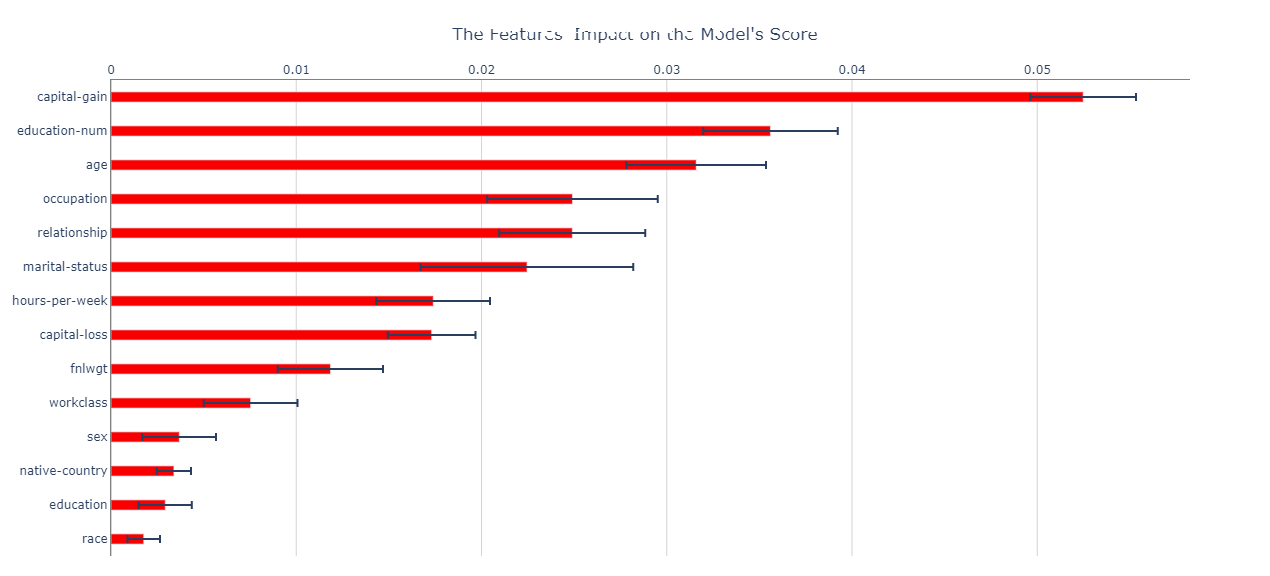

In [23]:
result_explain_model_default.show_in_notebook()

# 2 - Feature Dependence Explanations


## Partial Dependence Plots and Individual Conditional Expectations


Another way to measure dependency on a feature is through a partial dependence plot (PDP) or an individual conditional expectation (ICE) plot.

Given a dataset, a PDP displays the average output of the model as a function of the value of the selected set of features.

It can be computed for a single feature, as in the cell below. The X-axis is the value of the age feature and the y-axis is the corresponding outputted price. Since we are considering the whole dataset, the average over outputs is given by the red line, while the shaded interval corresponds to a 95% confidence interval for the average.

The histogram on top shows the distribution of the value of the age feature in the dataset.

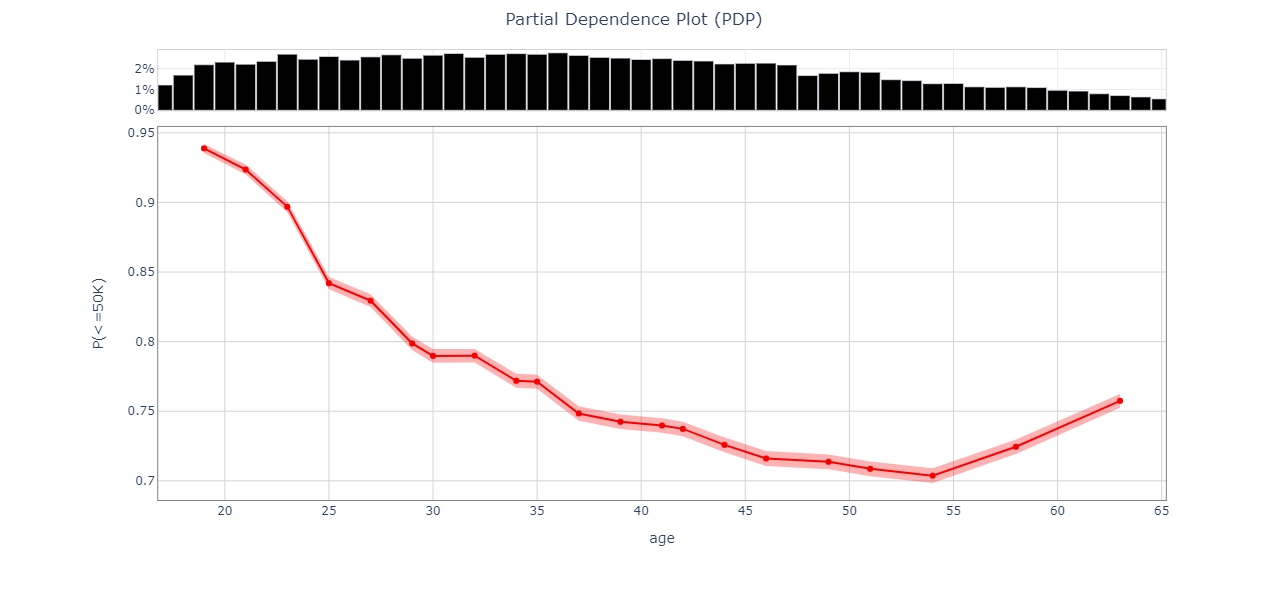

In [24]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence('age')
result_explain_feature_dependence_default.show_in_notebook()

In [54]:
result_explain_feature_dependence_default.to_dataframe()

race   age      Mean  Lower Bound  Upper Bound Target
0                Black  17.0 -0.012705    -0.012705    -0.012705  <=50K
1                Black  20.0 -0.012705    -0.012705    -0.012705  <=50K
2                Black  22.0 -0.014109    -0.014109    -0.014109  <=50K
3                Black  25.0 -0.008549    -0.008549    -0.008549  <=50K
4                Black  27.0 -0.007143    -0.007143    -0.007143  <=50K
..                 ...   ...       ...          ...          ...    ...
85  Asian-Pac-Islander  48.0 -0.005356          NaN          NaN   >50K
86  Asian-Pac-Islander  52.0 -0.003888          NaN          NaN   >50K
87  Asian-Pac-Islander  56.0 -0.002396          NaN          NaN   >50K
88  Asian-Pac-Islander  62.0  0.004205          NaN          NaN   >50K
89  Asian-Pac-Islander  90.0  0.008938          NaN          NaN   >50K

[180 rows x 6 columns]

The ICE plot is automatically computed at the same time as any one-feature PDP. They can be accessed by passing ice=True to show_in_notebook.

Similar to PDPs, ICE plots show the median prediction as a model red line. However, the variance in the model's predictions are shown by plotting the predictions of a sample of individual data instances as light grey lines. (For categorical features, the distribution in the predictions is instead shown as a violin plot.)

In [55]:
result_explain_feature_dependence_default.show_in_notebook(ice=True)

AutoMLxValueError: ICE plots cannot be displayed for ALEs. Please set ice=False.
Provided True.

We can also plot the PDP for up to four features. The plot below is the PDP for the race and sex features. The X-axis still shows the values of race, while there is a different bar and confidence interval for each value of the feature sex.

The histogram displays the joint distribution of the two features.

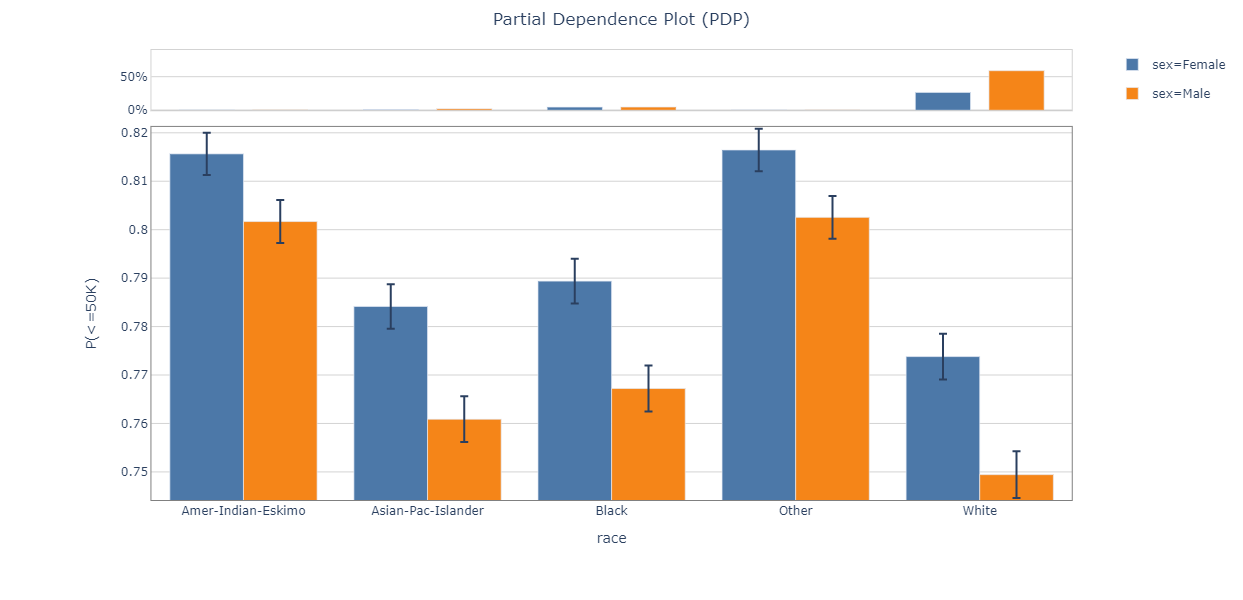

In [26]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(['race', 'sex'])
result_explain_feature_dependence_default.show_in_notebook()

PDPs can be comptued for an arbitrary number of variables; however, they can only be visualized with up to 4, as shown below.

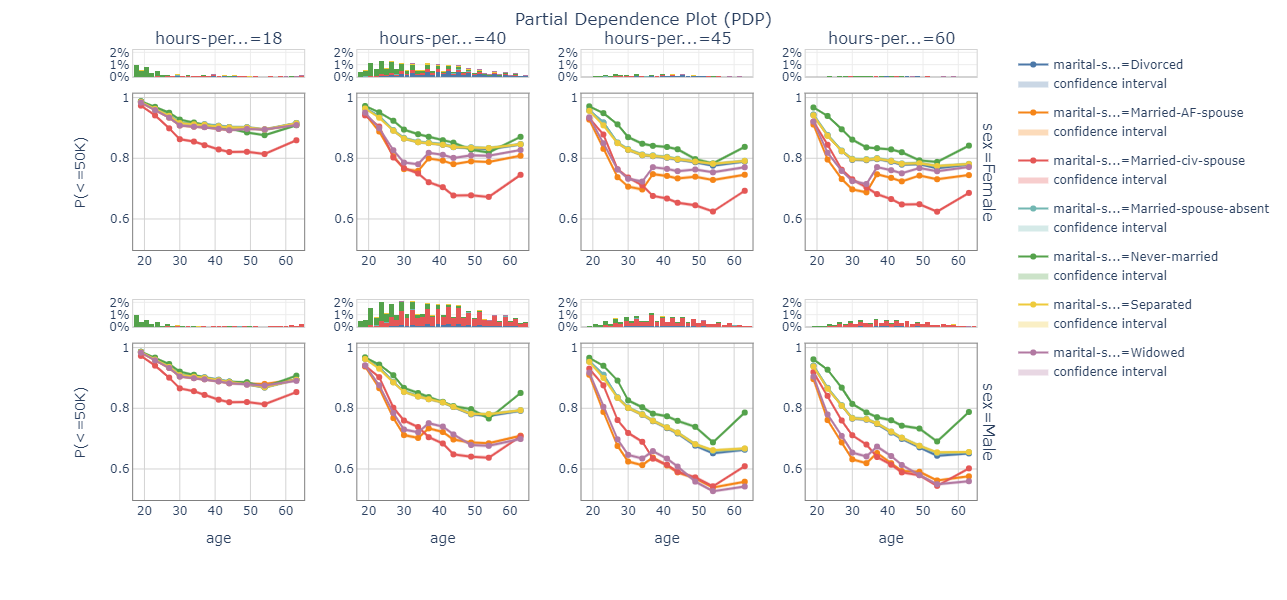

In [27]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(['age', 'hours-per-week', 
                                                                                  'sex', 'marital-status'])
result_explain_feature_dependence_default.show_in_notebook()

# Accumulated Local Effects


In addition to PDPs, Accumulated Local Effects (ALE) can be used to measure a model's dependency on a feature. ALE is considered a better alternative to PDPs when features are correlated, because it does not evaluate the model outside of its training distribution in these cases. For more information, see https://christophm.github.io/interpretable-ml-book/ale.html.

Given a dataset, an ALE displays the average output of the model, accumulated and computed over conditional distribution, as a function of the value of the selected set of features.

It can be computed for a single feature, as in the cell below. The X-axis is the value of the age feature and the y-axis is the corresponding computed ALE (price unit).

The histogram on top shows the distribution of the value of the age feature in the dataset.

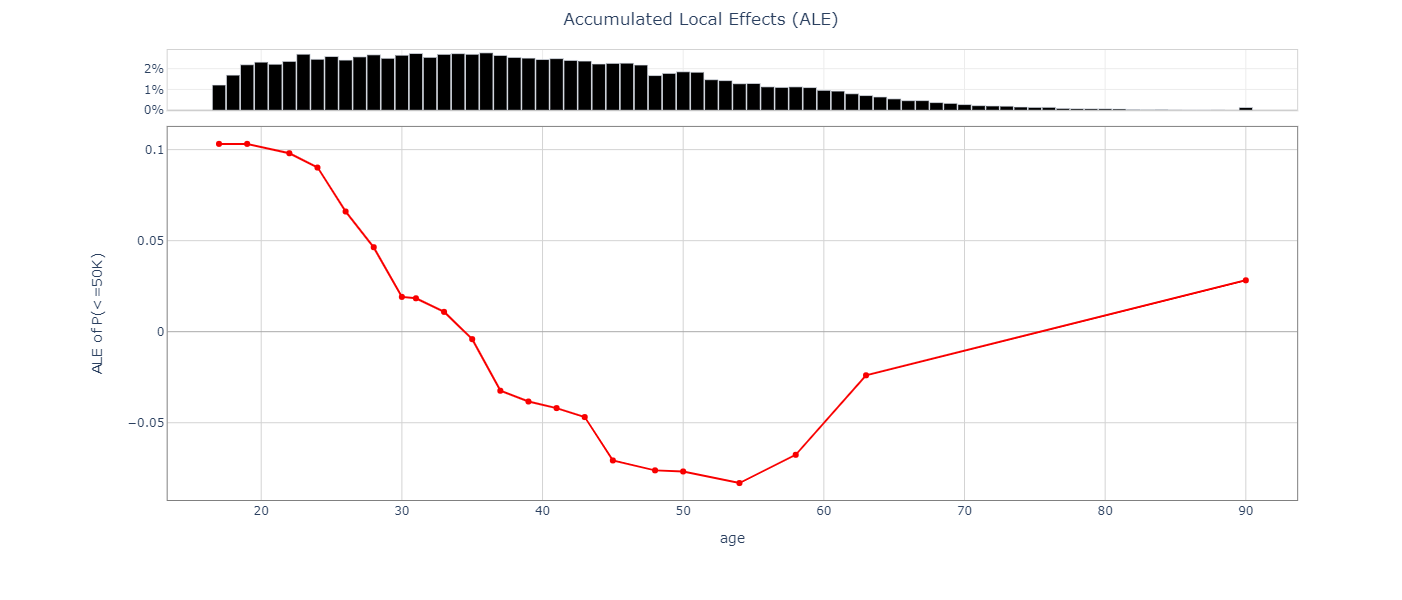

In [28]:
explainer.configure_explain_feature_dependence(explanation_type='ale')
result_explain_feature_dependence_default = explainer.explain_feature_dependence('age')
result_explain_feature_dependence_default.show_in_notebook()

We can also compute ALEs for two features (At least one is numerical). The plot below is the ALE plot for the age and race features. The X-axis still shows the values of age, while there is multiple lines, one for each value of the feature race.

The histogram displays the joint distribution of the two features.

In [ ]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(['age', 'race'])
result_explain_feature_dependence_default.show_in_notebook()

# 3 - Local feature importance (importance for a given sample)


Given a data sample, one can also obtain the local importance, which is the importance of the features for the model's prediction on that sample. In the following cell, we consider sample 
0
. The function explain_prediction() computes the local importance for a given sample.

capital-gain=2174 means that the value of feature capital-gain for that sample is 2174. Removing that feature would change the model's prediction by the magnitude of the bar. That is, in this case, the model's prediction for the probability that the person makes less than 50K is approximately 0.09 larger because the model knows the value of capital-gain is 2174.

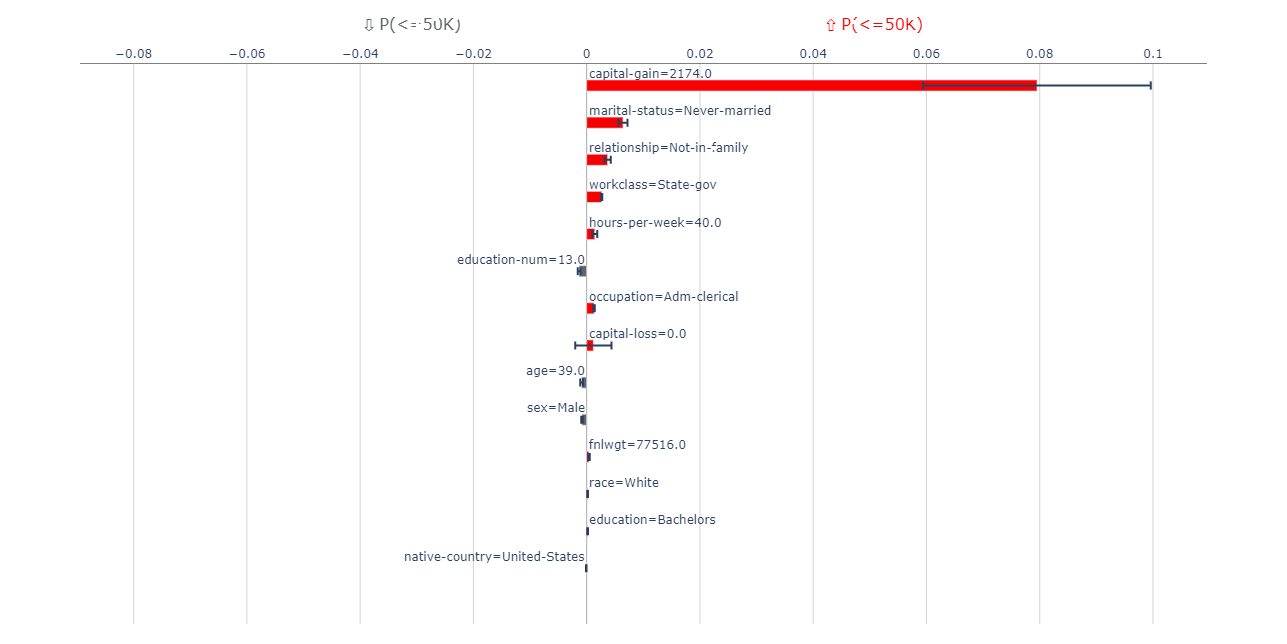

In [30]:
index = 0
result_explain_prediction_default = explainer.explain_prediction(X_train.iloc[index:index+1,:])
result_explain_prediction_default[0].show_in_notebook()

# 5 - Advanced feature importance configurations


We now display more advanced configuration for computing feature importance. Here, we will explain a custom scikit-learn model. Note that the MLExplainer object is capable to explain any classification model, as long as the model follows a scikit-learn-style interface with the predict and predict_proba functions.

We then create the explainer object.

In [31]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude=object)),
        ("cat", categorical_transformer, selector(dtype_include=object)),
    ]
)
scikit_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)


scikit_model.fit(X_train, y_train)

explainer_sklearn = automl.MLExplainer(scikit_model,
                                    X_train,
                                    y_train,
                                    target_names=["<=50K", ">50K"],
                                    task="classification")

5a - Changing the number of iterations
One can modify the number of iterations n_iter used to evaluate the global importance of the model, or the local importance of a prediction.

Increasing n_iter requires a linear increase in computation time. It however provides more accurate importance estimates, thereby decreasing the variance in repeated calls to explain_model/explain_prediction.

The default value is auto, which selects a suitable default value based on the choice of the method of explanation.

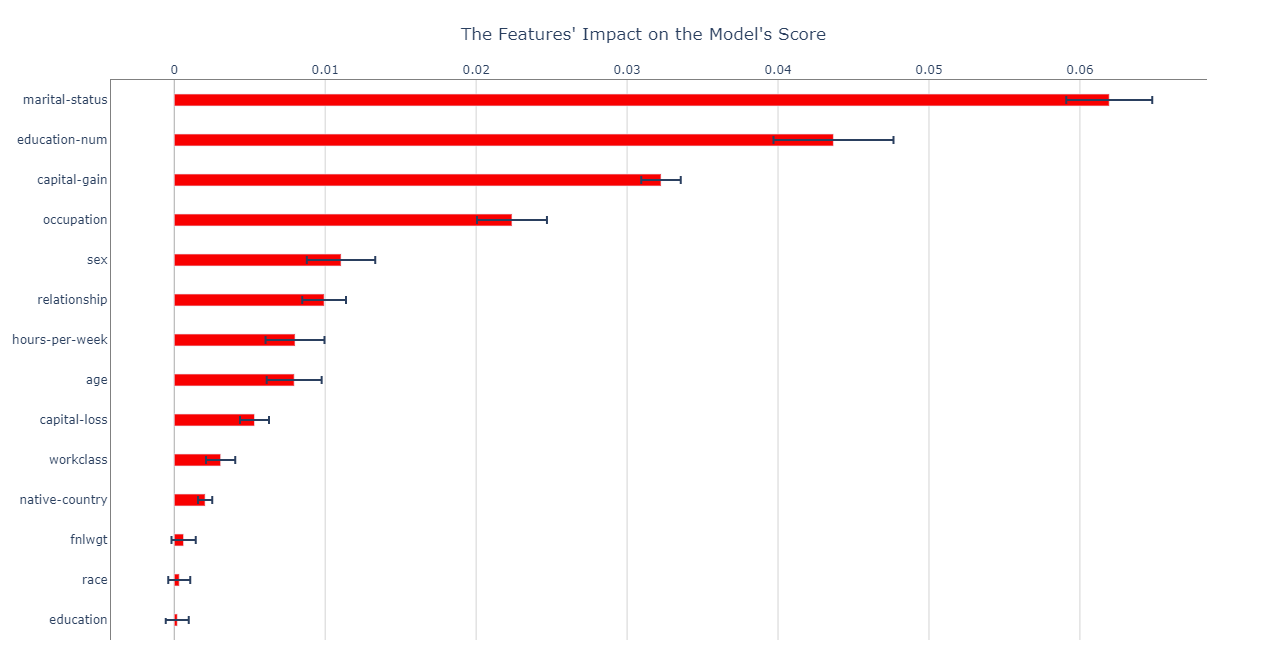

In [32]:
result_explain_model_increase_n_iter = explainer_sklearn.explain_model(n_iter=20)
result_explain_model_increase_n_iter.show_in_notebook()

5b - Including the effects of feature interactions (with Shapley feature importance)
The Oracle AutoMLx solution allows one to change the effect of feature interactions. This can be done through the tabulator_type argument of both global and local importance methods.

tabulator_type can be set to one of those three options: permutation, kernel_shap, shapley, shap_pi

permutation: This value is the default method in the MLExplainer object, and the behaviour was described above

kernel_shap: Feature importance attributions will be calculated using an approximation of the Shapley value method. It typically provides relatively high-quality approximations; however, it currently does not provide confidence intervals.

shapley: Feature importance is computed using the popular game-theoretic Shapley value method. Technically, this measures the importance of each feature while including the effect of all feature interactions. As a result, it runs in exponential time with respect to the number of features in the dataset. This method also includes the interaction effects of the other features, which means that if two features contain duplicate information, they will be less important. Note that the interpretation of this method's result is a bit different from the permutation method's result. An interested reader may find this a good source for learning more about it.

shap_pi: Feature importance attributions will be computed using an approximation of the Shapley value method. It runs in linear time, but may miss the effect of interactions between some features, which may therefore produce lower-quality results. Most likely, you will notice that this method yields larger confidence intervals than the other two.

Summary: permutation can miss important features for AD. Exact SHAP (shapley) doesn't, but it is exponential. kernel_shap is an approximation of exact SHAP method that does not provide confidence intervals. shap_pi is linear, thus faster than exact SHAP and kernel_shap but unstable and very random leads to lower quality approximations.

Global feature importance with kernel_shap

In [33]:
explainer_sklearn.configure_explain_model(tabulator_type="kernel_shap")

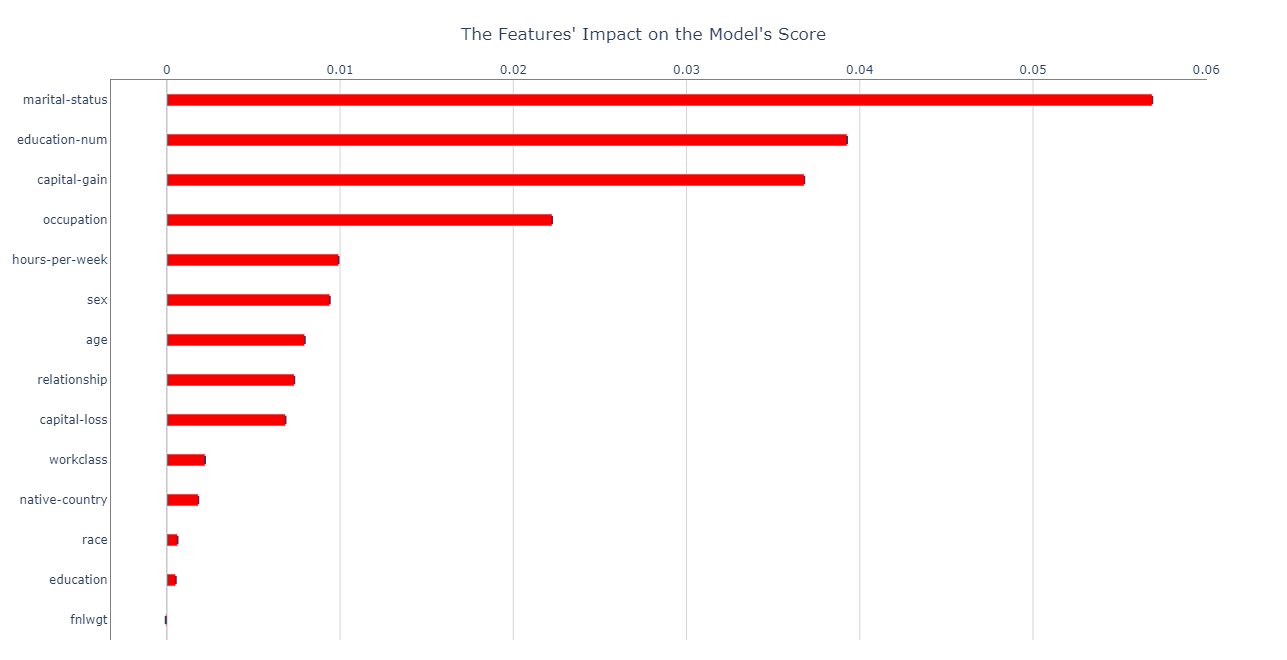

In [34]:
result_explain_model_kernel_shap = explainer_sklearn.explain_model()
result_explain_model_kernel_shap.show_in_notebook()

Local feature importance with kernel_shap

In [35]:
explainer_sklearn.configure_explain_prediction(tabulator_type="kernel_shap")

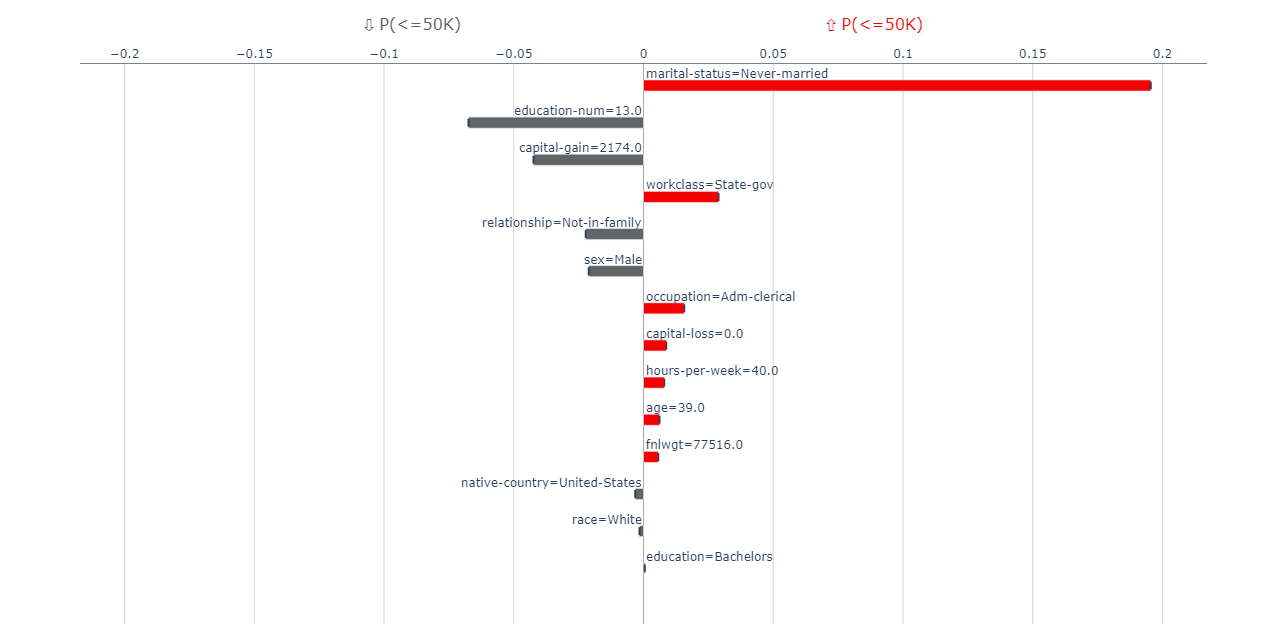

In [36]:
index = 0
result_explain_prediction_kernel_shap = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1,:])
result_explain_prediction_kernel_shap[0].show_in_notebook()

5c - Explain the model or Explain the world
Oracle AutoMLx solution also provides the evaluator_type attribute, which allows one to choose whether to get feature importance attributions that explain exactly which features the model has learned to use (interventional), or which features the model or a retrained model could have learned to use (observational).

interventional : The computed feature importances are as faithful to the model as possible. That is, features that are ignored by the model will not be considered important. This setting should be preferred if the primary goal is to learn about the machine learning model itself. Technically, this setting is called 'interventional', because the method will intervene on the data distribution when assessing the importance of features. The intuition of feature importance attributions computed with this method is that the features are dropped from the dataset and the model is not allowed to retrain.

observational : The computed feature importances are more faithful to the relationships that exist in the real world (i.e., relationships observed in the dataset), even if your specific model did not learn to use them. For example, when using a permutation tabulator, a feature that is used by the model will not show a large impact on the model's performance if there is a second feature that contains near-duplicate information, because a re-trained model could have learned to use the other feature instead. (Similarly, for Shapley-based tabulators, a feature that is ignored by the model may have a non-zero feature importance if it could have been used by the model to predict the target.) This setting should be preferred if the model is merely a means to learn more about the relationships that exist within the data. Technically, this setting is called 'observational', because it observes the relationships in the data without breaking the existing data distribution.


Explaining the model with observational evaluator_type

In [41]:
explainer_sklearn.configure_explain_model(evaluator_type="observational")

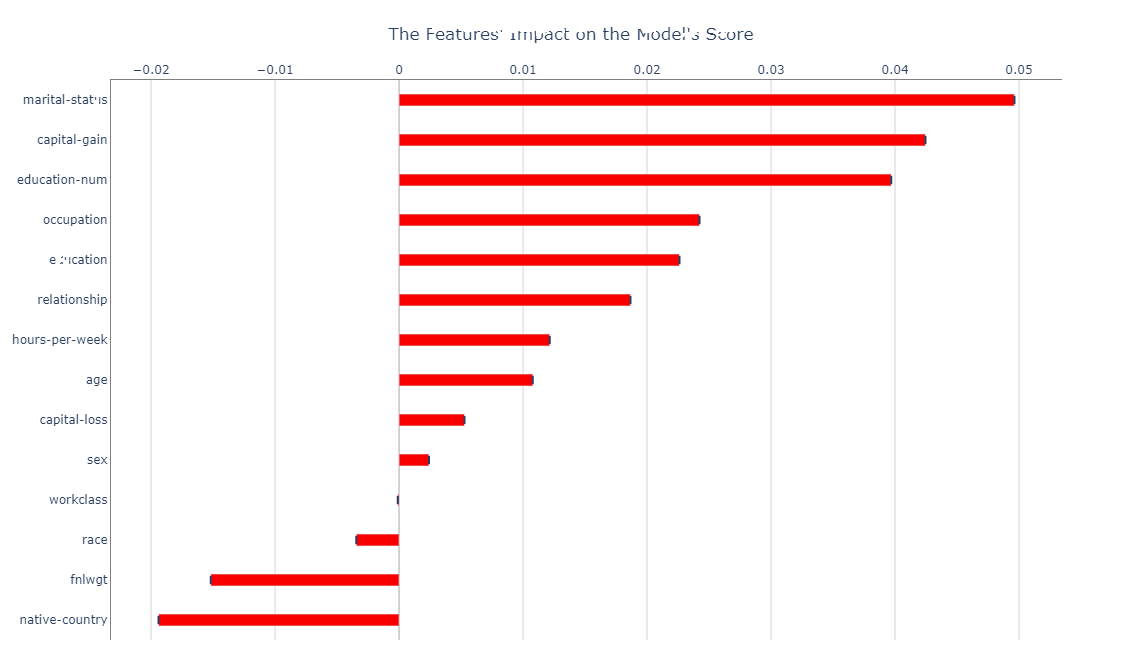

In [42]:
result_explain_model_kernel_shap = explainer_sklearn.explain_model()
result_explain_model_kernel_shap.show_in_notebook()

Explaining predictions with observational evaluator_type

In [ ]:
explainer_sklearn.configure_explain_prediction(evaluator_type="observational")

In [40]:
index = 0
result_explain_prediction_kernel_shap = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1,:])
result_explain_prediction_kernel_shap[0].show_in_notebook()


KeyboardInterrupt



# What-IF Tool


In [ ]:
explainer.explore_whatif(X_test, y_test)

The Oracle AutoMLx solution offers also What-IF tool to explain a trained ML model's predictions through a simple interactive interface.

You can use What-IF explainer to explore and visualize immediately how changing a sample value will affect the model's prediction. Forthermore, What-IF can be used to visualize how model's predictions are related to any feature of the dataset.

In [36]:
explainer = automl.MLExplainer(est1,
                               X_train,
                               y_train,
                               target_names=["<=50K", ">50K"],
                               task="classification",
                              )

explainer.explore_whatif(X_test, y_test)

Local feature importance using surrogate models
The Oracle AutoMLx solution allows one to change the type of local explainer effect of feature interactions. This can be done through the explainer_type argument of local importance methods.

explainer_type can be set to one of those two options: perturbation, surrogate

perturbation: This value is the default explainer type in local feature importance. As we showed above, the explanation(s) will be computed by perturbing the features of the indicated data instance(s) and measuring the impact on the model predictions.

surrogate: The LIME-style explanation(s) will be computed by fitting a surrogate model to the predictions of the original model in a small region around the indicated data instance(s) and measuring the importance of the features to the interpretable surrogate model. The method of surrogate explainer can be set to one of the following options:

lime: Local Interpretable Model-agnostic Explanations (LIME) algorithm (https://arxiv.org/pdf/1602.04938).
systematic: An improved version of LIME which utilizes a systematic sampling and cutom sample weighting. (This is one of our IPs)

Explaining predictions with surrogate explainer_type (lime)

In [ ]:
explainer_sklearn.configure_explain_prediction(explainer_type='surrogate')

Explaining predictions with surrogate explainer_type (systematic)

In [ ]:
explainer_sklearn.configure_explain_prediction(explainer_type='surrogate',
                                               method='systematic')

In [ ]:
index = 0
result_explain_prediction_surrogate_systematic = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1,:], 
                                                                                      y=y_train.iloc[index:index+1])
result_explain_prediction_surrogate_systematic[0].show_in_notebook()